# Goal
Draw the likelihood of a GP model with a standard GPyTorch SE kernel and zero mean on a dataset.  
Then calculate approximations to the likelihood via MCMC, AIC, AICc, BIC and the Laplace approximation and draw their values on top of the actual likelihood to show how close/far they are from the true value.

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
import gpytorch
import torch
import stan
from itertools import product
import numpy as np

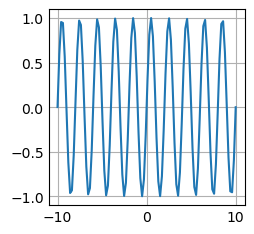

In [163]:
start = -10
end = 10
num_data = 100


train_x = torch.linspace(start, end, num_data)
train_y = torch.sin(3.1415*train_x)
plt.plot(train_x, train_y)

In [164]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [165]:
# MLL
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.tensor(1.0))
model = ExactGPModel(train_x, train_y, likelihood)
loss_list = list()

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


param_range = torch.linspace(-3, 1, 50)
full_range = list(product(param_range, param_range))
params_list = [p for p in model.parameters()]

for theta in enumerate(param_range):
    # Set parameter value
    model.covar_module.raw_lengthscale.data = torch.Tensor([theta])
    #model.likelihood.raw_noise.data = torch.Tensor([noise])
    # Output from model
    output = model(X)
    loss = mll(output, Y) *len(*model.train_inputs)
    try:
        env_grads   = torch.autograd.grad(loss, params_list, retain_graph=True, create_graph=True)
    except:
        import pdb
        pdb.set_trace()
    hess_params = []
    for i in range(len(env_grads)):
        hess_params.append(torch.autograd.grad(env_grads[i], params_list, retain_graph=True))
    # Calc loss and backprop gradients
    loss_list.append(loss.detach())

IndexError: tuple index out of range

ValueError: x and y must have same first dimension, but have shapes torch.Size([50]) and (0,)

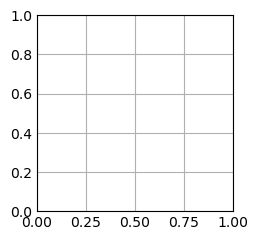

In [ ]:
plt.plot(param_range, loss_list)